# Parsing 1000Z Rigol Waveforms

**Scott Prahl**

**Mar 2020**

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

try:
    import RigolWFM.wfm as rigol

except:
    print("***** You need to install the module to read Rigol files first *****")
    print("***** Execute the following line in a new cell, then retry     *****")
    print()
    print("!{sys.executable} -m pip install RigolWFM")
    
def downsample(y, new_length):
    """Create new array with specifed length by averaging points."""
    ynew = np.empty(new_length)
    stride = len(y)/new_length
    for i in range(new_length):
        start = int(i*stride)
        end = int(i*stride+stride)
        ynew[i] = np.mean(y[start:end])
        
    return ynew

def lsf_with_errors(x,y):
    '''
    Find the least squares slope and intercept
    Args:
        x: array of x values
        y: array of y values
    Returns
        m: slope of fitted line
        b: intercept of fitted line
        sigma_m: estimated error in slope
        sigma_b: estimated error in intercept
    '''
    p,V = np.polyfit(x, y, 1, cov=True)
    m = p[0]
    b = p[1]
    sigma_m = np.sqrt(V[0][0])
    sigma_b = np.sqrt(V[1][1])
    return m, b, sigma_m, sigma_b

## Introduction

The goal of this notebook is to explain the origins of the raw data to voltage conversion on the Rigol 1000Z oscilloscope `.wfm` files and also validate the conversion against `.csv` files.  

**Alas, there is still something screwy about the conversion of raw bytes to volts.  Right now the vertical scaling seems correct, but the offset is still inconsistent with `.csv` values.**

The file format extracts the `volts_per_division` and `volts_offset` values, but using these with raw data required reading the [Rigol Programming Guide](https://www.batronix.com/pdf/Rigol/ProgrammingGuide/MSO1000Z_DS1000Z_ProgrammingGuide_EN.pdf) for the DS1000Z.

Two different `.wfm` files are examined, one for the [MSO1104Z](https://github.com/michal-szkutnik/pyRigolWfm1000Z/issues/1#issuecomment-212646090), one each for the [DS1074Z and DS1074Z Plus](https://github.com/michal-szkutnik/pyRigolWfm1000Z/issues/4#issue-361649641).

The list of Rigol scopes that should produce this same file format are:

In [2]:
print(rigol.DS1000Z_scopes[3:])

['DS1202Z', 'DS1074Z', 'DS1104Z', 'DS1074Z-S', 'DS1104Z-S', 'MSO1054Z', 'DS1054Z', 'MSO1074Z', 'MSO1104Z', 'DS1104Z']


## Background on the voltage and time conversions.

It is bit confusing because the `.wfm` files and the `.csv` files can differ.  I think that the `.wfm` files always correspond to the scope's `RAW` mode and the `.csv` files can be limited to just the display or `NORMAL` mode.

### Voltage conversion

From the [Rigol Programming Guide](https://www.batronix.com/pdf/Rigol/ProgrammingGuide/MSO1000Z_DS1000Z_ProgrammingGuide_EN.pdf)
    
page 2-221::
>    volts = (raw_byte - YORigin - YREFerence) * YINCrement

page 2-223, assuming `RAW` mode::
>    YINCrement = VerticalScale/25

>    YORigin = VerticalOffset/YINCrement

>    YREFerence is always 127
    
So this becomes::
>    volts = (raw_byte - VerticalOffset/YINCrement - 127) * YINCrement

>    volts = (raw_byte - 127) * YINCrement - VerticalOffset

>    volts = (raw_byte - 127) * VerticalScale/25 - VerticalOffset

and this can be interpreted as

>    volts = (raw_byte - 127.0) * VoltsPerDivision/25.0 - VerticalOffset

Where the decimal points are force python avoid integer math.

### Time Conversions

On page 2-222 we find that

`XINCrement` the time difference between two neighboring points of the specified channel source in the X direction and

> XINCrement = 1/SampleRate

on the other hand, when the scope is in `NORMAL` mode or display mode, then

> XINCrement = TimeScale/100

`XORigin` is the start time of the waveform data of the channel source currently selected in the X direction.

Both should be in seconds.

### CSV Files

#### Display saving

It seems that the time parameters provided in the `.csv` file (when saving the `display` points) is set so the center point is at time zero.  There are twelve divisions that are saved and each division has 100 points.  Therefore the time increment is given by

> time_increment = time_per_division/100

and the start time is

> -600 * time_increment

(There is probably an time offset also ...)

In [3]:
# raw=true is needed because this is a binary file
wfm_url = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z.wfm" + "?raw=true"  

w = rigol.Wfm.from_url(wfm_url, '1000Z')

description = w.describe()
print(description)

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z.wfm?raw=true'
    General:
        File Model   = wfm1000z
        User Model   = 1000Z
        Parser Model = wfm1000z
        Firmware     = unknown
        Filename     = DS1054Z.wfm
        Channels     = [1, 2, 3, 4]

     Channel 1:
         Coupling =       DC
            Scale =     2.00  V/div
           Offset =     1.00  V
            Probe =      10X

        Time Base =   50.000 ns/div
           Offset =    0.000  s
            Delta =    4.000 ns/point
           Points =      278

         Count    = [        1,        2,        3  ...       277,      278]
           Raw    = [      158,      157,      159  ...       176,      176]
           Times  = [-556.000 ns,-551.986 ns,-547.971 ns  ... 551.986 ns,556.000 ns]
           Volts  = [  2.10  V,  2.00  V,  2.20  V  ...   3.90  V,  3.90  V]

     Channel 2:
         Coupling =       DC
            Scale =     2.00  V/div
           Offset =    -1

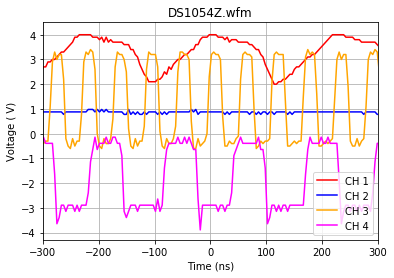

In [4]:
w.plot()
plt.legend()
plt.xticks(np.linspace(-300,300,7))
plt.xlim(-300,300)
plt.grid(True)
plt.show()

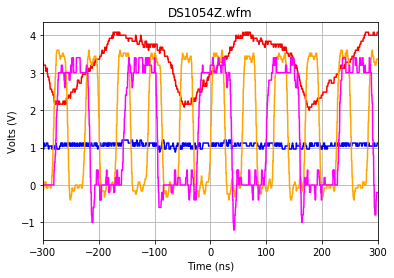

In [5]:
csv_filename = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z.csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2).T

# construct times for each point using values from the second line of the .csv file
t_incr = 5.000000e-10      # seconds/point
t_start = -600 * t_incr    # seconds so that t=0 is in the center

csv_times = csv_data[0] * t_incr + t_start   # seconds

plt.plot(csv_times*1e9, csv_data[1],color='red')
plt.plot(csv_times*1e9, csv_data[2],color='blue')
plt.plot(csv_times*1e9, csv_data[3],color='orange')
plt.plot(csv_times*1e9, csv_data[4],color='magenta')

plt.xlabel("Time (ns)")
plt.ylabel("Volts (V)")
plt.grid(True)
#plt.xlim(-2,22)
plt.title("DS1054Z.wfm")
plt.xticks(np.linspace(-300,300,7))
plt.xlim(-300,300)
plt.show()

scale  = -0.100
v/div  = 2.000
offset = 1.000


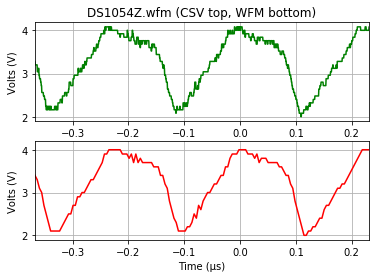

scale  = -0.100
v/div  = 2.000
offset = -1.180


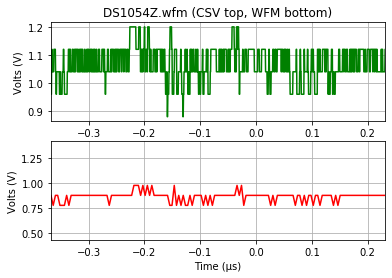

scale  = -0.100
v/div  = 2.000
offset = -5.600


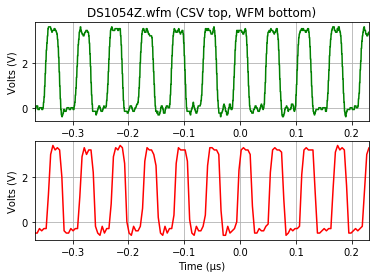

scale  = -0.250
v/div  = 5.000
offset = -21.360


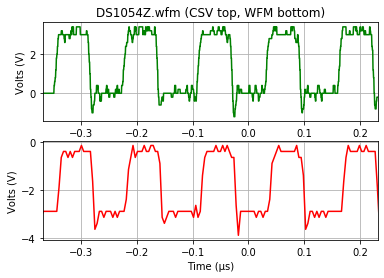

In [6]:
def compare(w, csv_data, channel_number, time_offset=0):
    ch = w.channels[channel_number-1]

    t=csv_data[0]
    y=csv_data[channel_number]
    tt = 0.5*t/1000-time_offset # microseconds

    print("scale  = %.3f" % ch.volt_scale)
    print("v/div  = %.3f" % ch.volt_per_division)
    print("offset = %.3f" % ch.volt_offset)

    plt.subplot(211)
    plt.plot(tt, y, color='green')
    plt.title("%s (CSV top, WFM bottom)" % w.basename)
    plt.ylabel("Volts (V)")
    plt.grid(True)
    plt.xlim(tt[0],tt[-1])

    plt.subplot(212)
    plt.plot(ch.times*1e6, ch.volts, color='red')
    plt.xlabel("Time (µs)")
    plt.ylabel("Volts (V)")
    plt.xlim(tt[0],tt[-1])
    plt.grid(True)

    plt.show()

for ch in [1,2,3,4]:
    compare(w,csv_data,ch,0.368)

## Start with waveform with a single trace

Start with a `.wfm` file from a Rigol MSO1104 scope.

First let's look at the description of the internal file structure. We see that only channel 1 has been enabled.  Unfortunately, there is not an accompanying `.csv` file.

In [7]:
# raw=true is needed because this is a binary file
wfm_url = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/MSO1104.wfm" + "?raw=true"  

w = rigol.Wfm.from_url(wfm_url, '1000Z')

description = w.describe()
print(description)

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/MSO1104.wfm?raw=true'
    General:
        File Model   = wfm1000z
        User Model   = 1000Z
        Parser Model = wfm1000z
        Firmware     = unknown
        Filename     = MSO1104.wfm
        Channels     = [1]

     Channel 1:
         Coupling =       AC
            Scale =     5.00  V/div
           Offset =    -4.60  V
            Probe =      10X

        Time Base =    1.000 ms/div
           Offset = -200.000 ps
            Delta = 1000.000 ns/point
           Points =  1200512

         Count    = [        1,        2,        3  ...   1200511,  1200512]
           Raw    = [      174,      175,      176  ...        70,       70]
           Times  = [-600.256 ms,-600.255 ms,-600.254 ms  ... 600.255 ms,600.256 ms]
           Volts  = [ 16.35  V, 16.60  V, 16.85  V  ...  -9.65  V, -9.65  V]




There are a lot of points, so just look the first and last 500 bytes in the `.wfm` file. Close-up the signal is a sinusoid.  A quick plot of the beginning and end of the data is shown below.

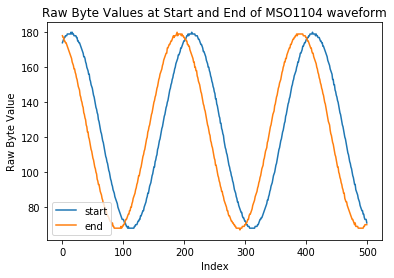

In [8]:
ch = w.channels[0]
plt.plot(ch.raw[:500], label="start")
plt.plot(ch.raw[-500:], label="end")

plt.xlabel("Index")
plt.ylabel("Raw Byte Value")

plt.title("Raw Byte Values at Start and End of MSO1104 waveform")
plt.legend()
plt.show()

Trying to create a function to convert to volts.  This one is at least plausible.

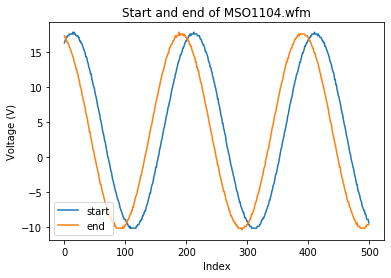

In [9]:
plt.plot(ch.volts[:500], label="start")
plt.plot(ch.volts[-500:], label="end")

plt.xlabel("Index")
plt.ylabel("Voltage (V)")
plt.title("Start and end of MSO1104.wfm")
plt.legend()
plt.show()

And finally, a graph with the real time units.

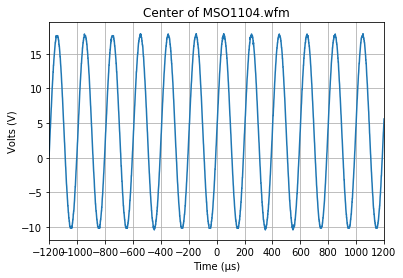

In [10]:
plt.plot(ch.times*1e6, ch.volts)
plt.xlabel("Time (µs)")
plt.ylabel("Volts (V)")
plt.xlim(-1200,1200)
plt.title("Center of MSO1104.wfm")
plt.xticks(np.linspace(-1200,1200,13))
plt.grid(True)
plt.show()

## DS1074Z Scope file

This `.wfm` file has an accompanying `.csv` file.  The difference between these two files is that the `.csv` file has been downsampled to 1200 points.  The `.wfm` has 3000128 bytes.

<img src="https://user-images.githubusercontent.com/43404500/45744052-0b897080-bbed-11e8-8d96-d46fd7e4c9c7.png" width="170%">

Here we just validate that the `.csv` file has the same values

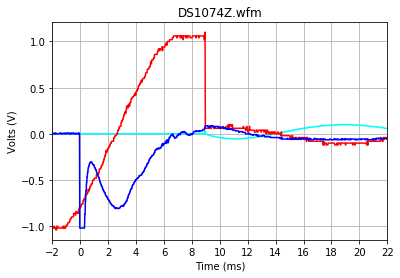

In [11]:
csv_filename = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-A.csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2).T

# construct times for each point using values from the second line of the .csv file
t_start = -2.000000e-03  # seconds
t_incr = 2.000000e-05    # seconds/point

csv_times = csv_data[0] * t_incr + t_start   # seconds

plt.plot(csv_times*1000, csv_data[1],color='cyan')
plt.plot(csv_times*1000, csv_data[2],color='red')
plt.plot(csv_times*1000, csv_data[3],color='blue')

plt.xlabel("Time (ms)")
plt.ylabel("Volts (V)")
plt.grid(True)
plt.xlim(-2,22)
plt.title("DS1074Z.wfm")
plt.xticks(np.linspace(-2,22,13))

plt.show()

In [12]:
wfm_url = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-A.wfm" + "?raw=true"  

w = rigol.Wfm.from_url(wfm_url, '1000Z')
description = w.describe()

print(description)

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-A.wfm?raw=true'
    General:
        File Model   = wfm1000z
        User Model   = 1000Z
        Parser Model = wfm1000z
        Firmware     = unknown
        Filename     = DS1074Z-A.wfm
        Channels     = [1, 2, 3]

     Channel 1:
         Coupling =       AC
            Scale =    50.00 mV/div
           Offset =   -50.00 mV
            Probe =       1X

        Time Base =    2.000 ms/div
           Offset =   10.000 ms
            Delta =    8.000 ns/point
           Points =  3000128

         Count    = [        1,        2,        3  ...   3000127,  3000128]
           Raw    = [      115,      115,      115  ...       140,      140]
           Times  = [-2.001 ms,-2.001 ms,-2.000 ms  ... 22.001 ms,22.001 ms]
           Volts  = [ 20.00 mV, 20.00 mV, 20.00 mV  ...  82.50 mV, 82.50 mV]

     Channel 2:
         Coupling =       AC
            Scale =   500.00 mV/div
           Offset =  -500.00 mV


Let's examine the second waveform in detail.  The Rigol screenshot shows that it goes from -1V to about 1.1V.  We will use the downsample function defined above to reduce the waveform signal to same number of datapoints as the `.csv` file has.

scale  = -0.025
v/div  = 0.500
offset = -0.500


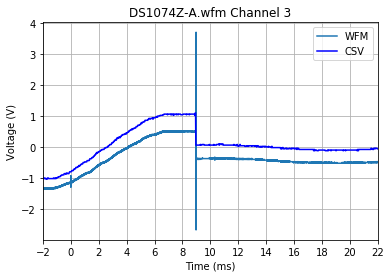

In [13]:
ch_no = 1
ch = w.channels[ch_no]

print("scale  = %.3f" % ch.volt_scale)
print("v/div  = %.3f" % ch.volt_per_division)
print("offset = %.3f" % ch.volt_offset)

plt.plot(ch.times*1000, ch.volts, label="WFM")
plt.plot(csv_times*1000, csv_data[ch_no+1],color='blue', label="CSV")

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.title("DS1074Z-A.wfm Channel 3")
plt.legend(loc='upper right')
plt.xlim(-2,22)
plt.xticks(np.linspace(-2,22,13))

plt.show()

scale  = -0.010
v/div  = 0.200
offset = -0.200


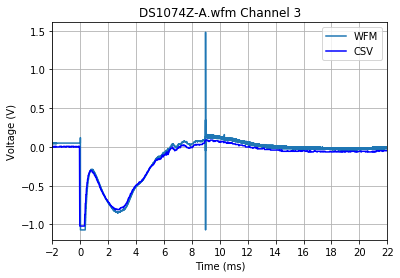

In [14]:
ch_no = 2
ch = w.channels[ch_no]

print("scale  = %.3f" % ch.volt_scale)
print("v/div  = %.3f" % ch.volt_per_division)
print("offset = %.3f" % ch.volt_offset)

plt.plot(ch.times*1000, ch.volts, label="WFM")
plt.plot(csv_times*1000, csv_data[ch_no+1],color='blue', label="CSV")

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.title("DS1074Z-A.wfm Channel 3")
plt.legend(loc='upper right')
plt.xlim(-2,22)
plt.xticks(np.linspace(-2,22,13))

plt.show()

scale  = -0.003
v/div  = 0.050
offset = -0.050


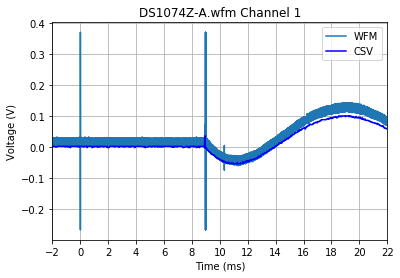

In [15]:
ch_no = 0
ch = w.channels[ch_no]

print("scale  = %.3f" % ch.volt_scale)
print("v/div  = %.3f" % ch.volt_per_division)
print("offset = %.3f" % ch.volt_offset)

plt.plot(ch.times*1000, ch.volts, label="WFM")
plt.plot(csv_times*1000, csv_data[ch_no+1],color='blue', label="CSV")


plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.title("DS1074Z-A.wfm Channel 1")
plt.legend(loc='upper right')
plt.xlim(-2,22)
plt.xticks(np.linspace(-2,22,13))

plt.show()